- 1.We start with a set of documentation specified by a user
- 2. We use a long context LLM to ingest it and perform RAG to answer a question based upon it
- 3. We will invoke a tool to produce a structured output
- 4. We will perform two unit tests (check imports and code execution) prior returning the solution to the user

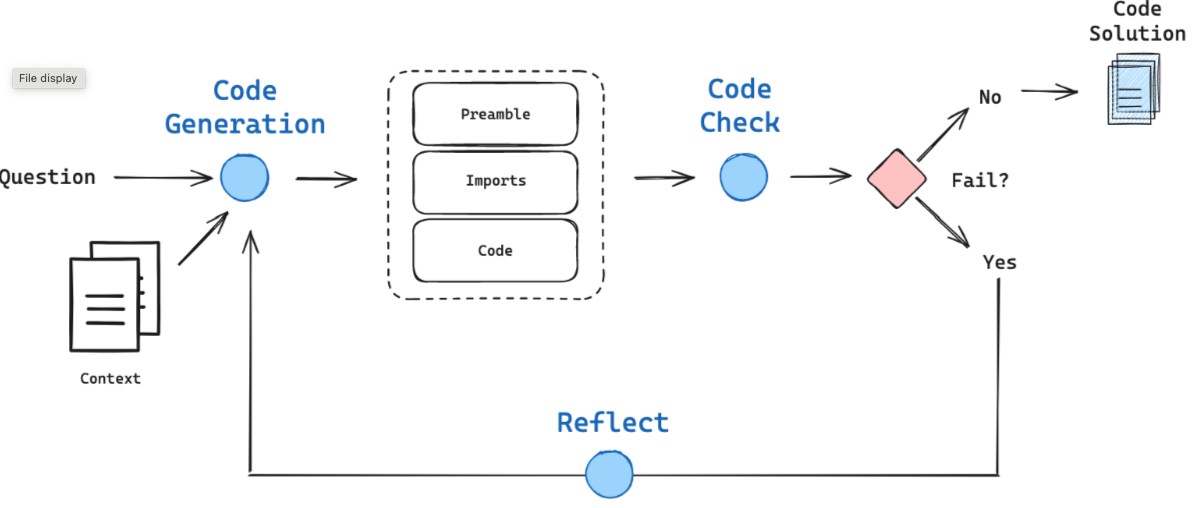

In [ ]:
pip install langchain_anthropic

In [19]:
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
from bs4 import BeautifulSoup as Soup
from langchain_community.document_loaders.recursive_url_loader import RecursiveUrlLoader

# LCEL docs
url = "https://python.langchain.com/docs/concepts/lcel/"
loader = RecursiveUrlLoader(
    url=url, max_depth=20, extractor=lambda x: Soup(x, "html.parser").text
)
docs = loader.load()

# Sort the list based on the URLs and get the text
d_sorted = sorted(docs, key=lambda x: x.metadata["source"])
d_reversed = list(reversed(d_sorted))
concatenated_content = "\n\n\n --- \n\n\n".join(
    [doc.page_content for doc in d_reversed]
)
print(concatenated_content)

/Users/kevinluo/Library/Mobile Documents/com~apple~CloudDocs/專給macbook用/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(







LangChain Expression Language (LCEL) | 🦜️🔗 LangChain






Skip to main contentIntegrationsAPI ReferenceMoreContributingPeopleError referenceLangSmithLangGraphLangChain HubLangChain JS/TSv0.3v0.3v0.2v0.1💬SearchIntroductionTutorialsBuild a Question Answering application over a Graph DatabaseTutorialsBuild a simple LLM application with chat models and prompt templatesBuild a ChatbotBuild a Retrieval Augmented Generation (RAG) App: Part 2Build an Extraction ChainBuild an AgentTaggingBuild a Retrieval Augmented Generation (RAG) App: Part 1Build a semantic search engineBuild a Question/Answering system over SQL dataSummarize TextHow-to guidesHow-to guidesHow to use tools in a chainHow to use a vectorstore as a retrieverHow to add memory to chatbotsHow to use example selectorsHow to add a semantic layer over graph databaseHow to invoke runnables in parallelHow to stream chat model responsesHow to add default invocation args to a RunnableHow to add retrieval to chatbotsHow to use few sho

In [3]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from pydantic import BaseModel, Field

### OpenAI

# Grader prompt
code_gen_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """You are a coding assistant with expertise in LCEL, LangChain expression language. \n 
    Here is a full set of LCEL documentation:  \n ------- \n  {context} \n ------- \n Answer the user 
    question based on the above provided documentation. Ensure any code you provide can be executed \n 
    with all required imports and variables defined. Structure your answer with a description of the code solution. \n
    Then list the imports. And finally list the functioning code block. Here is the user question:""",
        ),
        ("placeholder", "{messages}"),
    ]
)


# Data model
class code(BaseModel):
    """Schema for code solutions to questions about LCEL."""

    prefix: str = Field(description="Description of the problem and approach")
    imports: str = Field(description="Code block import statements")
    code: str = Field(description="Code block not including import statements")


expt_llm = "gpt-4o-mini"
llm = ChatOpenAI(temperature=0, model=expt_llm)
code_gen_chain_oai = code_gen_prompt | llm.with_structured_output(code)
question = "How do I build a RAG chain in LCEL?"
solution = code_gen_chain_oai.invoke(
    {"context": concatenated_content, "messages": [("user", question)]}
)
print(solution)

prefix='To build a Retrieval Augmented Generation (RAG) chain in LCEL, you will typically combine a retriever with a language model (LLM) and an output parser. The retriever fetches relevant documents based on a query, the LLM generates a response based on those documents, and the output parser formats the response. This can be achieved using the `RunnableSequence` to chain these components together. Below is an example of how to set this up.' imports='from langchain_core.runnables import RunnableSequence\nfrom langchain_core.runnables import RunnableParallel\nfrom langchain_core.runnables import RunnableLambda\n\n# Assuming retriever, llm, and output_parser are already defined' code='# Define the RAG chain\nrag_chain = RunnableSequence([\n    retriever,  # Step 1: Retrieve relevant documents\n    llm,        # Step 2: Generate response using LLM\n    output_parser  # Step 3: Parse the output\n])\n\n# Invoke the RAG chain with a query\nfinal_output = rag_chain.invoke(query)'


'''
prefix='To build a Retrieval Augmented Generation (RAG) chain in LCEL, you will typically combine a retriever with a language model (LLM) and an output parser. The retriever fetches relevant documents based on a query, the LLM generates a response based on those documents, and the output parser formats the response. This can be achieved using the `RunnableSequence` to chain these components together. Below is an example of how to set this up.' imports='from langchain_core.runnables import RunnableSequence\nfrom langchain_core.runnables import RunnableParallel\nfrom langchain_core.runnables import RunnableLambda\n\n# Assuming retriever, llm, and output_parser are already defined' code='# Define the RAG chain\nrag_chain = RunnableSequence([\n    retriever,  
#### Step 1: Retrieve relevant documents\n    llm,        
#### Step 2: Generate response using LLM\n    output_parser  
##### Step 3: Parse the output\n])\n\n# Invoke the RAG chain with a query\nfinal_output = rag_chain.invoke(query)'
'''

In [8]:
from langchain_anthropic import ChatAnthropic
from langchain_core.prompts import ChatPromptTemplate

### Anthropic

# Prompt to enforce tool use
code_gen_prompt_claude = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """<instructions> You are a coding assistant with expertise in LCEL, LangChain expression language. \n 
    Here is the LCEL documentation:  \n ------- \n  {context} \n ------- \n Answer the user  question based on the \n 
    above provided documentation. Ensure any code you provide can be executed with all required imports and variables \n
    defined. Structure your answer: 1) a prefix describing the code solution, 2) the imports, 3) the functioning code block. \n
    Invoke the code tool to structure the output correctly. </instructions> \n Here is the user question:""",
        ),
        ("placeholder", "{messages}"),
    ]
)


# LLM
expt_llm = "claude-3-opus-20240229"
llm = ChatAnthropic(
    model=expt_llm,
    default_headers={"anthropic-beta": "tools-2024-04-04"},
)

structured_llm_claude = llm.with_structured_output(code, include_raw=True)


# Optional: Check for errors in case tool use is flaky
def check_claude_output(tool_output):
    """Check for parse error or failure to call the tool"""

    # Error with parsing
    if tool_output["parsing_error"]:
        # Report back output and parsing errors
        print("Parsing error!")
        raw_output = str(tool_output["raw"].content)
        error = tool_output["parsing_error"]
        raise ValueError(
            f"Error parsing your output! Be sure to invoke the tool. Output: {raw_output}. \n Parse error: {error}"
        )

    # Tool was not invoked
    elif not tool_output["parsed"]:
        print("Failed to invoke tool!")
        raise ValueError(
            "You did not use the provided tool! Be sure to invoke the tool to structure the output."
        )
    return tool_output


# Chain with output check
code_chain_claude_raw = (
    code_gen_prompt_claude | structured_llm_claude | check_claude_output
)


def insert_errors(inputs):
    """Insert errors for tool parsing in the messages"""

    # Get errors
    error = inputs["error"]
    messages = inputs["messages"]
    messages += [
        (
            "assistant",
            f"Retry. You are required to fix the parsing errors: {error} \n\n You must invoke the provided tool.",
        )
    ]
    return {
        "messages": messages,
        "context": inputs["context"],
    }


# This will be run as a fallback chain
fallback_chain = insert_errors | code_chain_claude_raw
N = 3  # Max re-tries
code_gen_chain_re_try = code_chain_claude_raw.with_fallbacks(
    fallbacks=[fallback_chain] * N, exception_key="error"
)


def parse_output(solution):
    """When we add 'include_raw=True' to structured output,
    it will return a dict w 'raw', 'parsed', 'parsing_error'."""

    return solution["parsed"]


# Optional: With re-try to correct for failure to invoke tool
code_gen_chain = code_gen_chain_re_try | parse_output

# No re-try
code_gen_chain = code_gen_prompt_claude | structured_llm_claude | parse_output

In [10]:
# Test
question = "How do I build a RAG chain in LCEL?"
solution = code_gen_chain.invoke(
    {"context": concatenated_content, "messages": [("user", question)]}
)
print(solution)

prefix="Here's how you can build a Retrieval Augmented Generation (RAG) chain using the LangChain Expression Language (LCEL):" imports='from langchain.llms import OpenAI\nfrom langchain.retrievers import TFIDFRetriever \nfrom langchain.prompts import PromptTemplate\nfrom langchain_core.chains import RunnableSequence' code='llm = OpenAI()\nretriever = TFIDFRetriever(documents)\n\nprompt_template = """Use the following context to answer the question at the end.\n\nContext: \n{documents}\n\nQuestion: {question}\n\nAnswer:"""\nprompt = PromptTemplate.from_template(prompt_template)\n\ncombine_prompt_docs = RunnableLambda(lambda x: {"question": x["question"], "documents": "\\n\\n".join(x["documents"])})\n\nrag_chain = retriever | combine_prompt_docs | prompt | llm\n\nresult = rag_chain.invoke({"question": "What is the capital of France?"})'


imports='from langchain.llms import OpenAI\nfrom langchain.retrievers import TFIDFRetriever \nfrom langchain.prompts import PromptTemplate\nfrom langchain_core.chains import RunnableSequence' code='llm = OpenAI()\nretriever = TFIDFRetriever(documents)\n\nprompt_template = """Use the following context to answer the question at the end.\n\nContext: \n{documents}\n\nQuestion: {question}\n\nAnswer:"""\nprompt = PromptTemplate.from_template(prompt_template)\n\ncombine_prompt_docs = RunnableLambda(lambda x: {"question": x["question"], "documents": "\\n\\n".join(x["documents"])})\n\nrag_chain = retriever | combine_prompt_docs | prompt | llm\n\nresult = rag_chain.invoke({"question": "What is the capital of France?"})

In [11]:
from typing import List
from typing_extensions import TypedDict


class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        error : Binary flag for control flow to indicate whether test error was tripped
        messages : With user question, error messages, reasoning
        generation : Code solution
        iterations : Number of tries
    """

    error: str
    messages: List
    generation: str
    iterations: int

In [12]:
### Parameter

# Max tries
max_iterations = 3
# Reflect
# flag = 'reflect'
flag = "do not reflect"

### Nodes


def generate(state: GraphState):
    """
    Generate a code solution

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation
    """

    print("---GENERATING CODE SOLUTION---")

    # State
    messages = state["messages"]
    iterations = state["iterations"]
    error = state["error"]

    # We have been routed back to generation with an error
    if error == "yes":
        messages += [
            (
                "user",
                "Now, try again. Invoke the code tool to structure the output with a prefix, imports, and code block:",
            )
        ]

    # Solution
    code_solution = code_gen_chain.invoke(
        {"context": concatenated_content, "messages": messages}
    )
    messages += [
        (
            "assistant",
            f"{code_solution.prefix} \n Imports: {code_solution.imports} \n Code: {code_solution.code}",
        )
    ]

    # Increment
    iterations = iterations + 1
    return {"generation": code_solution, "messages": messages, "iterations": iterations}


def code_check(state: GraphState):
    """
    Check code

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, error
    """

    print("---CHECKING CODE---")

    # State
    messages = state["messages"]
    code_solution = state["generation"]
    iterations = state["iterations"]

    # Get solution components
    imports = code_solution.imports
    code = code_solution.code

    # Check imports
    try:
        exec(imports)
    except Exception as e:
        print("---CODE IMPORT CHECK: FAILED---")
        error_message = [("user", f"Your solution failed the import test: {e}")]
        messages += error_message
        return {
            "generation": code_solution,
            "messages": messages,
            "iterations": iterations,
            "error": "yes",
        }

    # Check execution
    try:
        exec(imports + "\n" + code)
    except Exception as e:
        print("---CODE BLOCK CHECK: FAILED---")
        error_message = [("user", f"Your solution failed the code execution test: {e}")]
        messages += error_message
        return {
            "generation": code_solution,
            "messages": messages,
            "iterations": iterations,
            "error": "yes",
        }

    # No errors
    print("---NO CODE TEST FAILURES---")
    return {
        "generation": code_solution,
        "messages": messages,
        "iterations": iterations,
        "error": "no",
    }


def reflect(state: GraphState):
    """
    Reflect on errors

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation
    """

    print("---GENERATING CODE SOLUTION---")

    # State
    messages = state["messages"]
    iterations = state["iterations"]
    code_solution = state["generation"]

    # Prompt reflection

    # Add reflection
    reflections = code_gen_chain.invoke(
        {"context": concatenated_content, "messages": messages}
    )
    messages += [("assistant", f"Here are reflections on the error: {reflections}")]
    return {"generation": code_solution, "messages": messages, "iterations": iterations}


### Edges


def decide_to_finish(state: GraphState):
    """
    Determines whether to finish.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """
    error = state["error"]
    iterations = state["iterations"]

    if error == "no" or iterations == max_iterations:
        print("---DECISION: FINISH---")
        return "end"
    else:
        print("---DECISION: RE-TRY SOLUTION---")
        if flag == "reflect":
            return "reflect"
        else:
            return "generate"

In [13]:
from langgraph.graph import END, StateGraph, START

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("generate", generate)  # generation solution
workflow.add_node("check_code", code_check)  # check code
workflow.add_node("reflect", reflect)  # reflect

# Build graph
workflow.add_edge(START, "generate")
workflow.add_edge("generate", "check_code")
workflow.add_conditional_edges(
    "check_code",
    decide_to_finish,
    {
        "end": END,
        "reflect": "reflect",
        "generate": "generate",
    },
)
workflow.add_edge("reflect", "generate")
app = workflow.compile()

In [14]:
question = "How can I directly pass a string to a runnable and use it to construct the input needed for my prompt?"
solution = app.invoke({"messages": [("user", question)], "iterations": 0, "error": ""})

---GENERATING CODE SOLUTION---
---CHECKING CODE---
---CODE IMPORT CHECK: FAILED---
---DECISION: RE-TRY SOLUTION---
---GENERATING CODE SOLUTION---
---CHECKING CODE---
---CODE BLOCK CHECK: FAILED---
---DECISION: RE-TRY SOLUTION---
---GENERATING CODE SOLUTION---
---CHECKING CODE---
---CODE IMPORT CHECK: FAILED---
---DECISION: FINISH---


In [16]:
solution['generation']

code(prefix='To directly pass a string to a runnable and use it to construct the input for your prompt, you can use a RunnableFormat instance with a format string. RunnableFormat allows you to specify a format string that will be filled in with values from the input dictionary when the runnable is invoked.', imports='from langchain.prompts import PromptTemplate\nfrom langchain_core.runnables import RunnableFormat', code='template = "My name is {name}"\nformat_runnable = RunnableFormat(template)\n\nprompt = PromptTemplate(\n    input_variables=["formatted_string"], \n    template="{formatted_string}. What is your favorite color?"\n)\n\nchain = format_runnable | prompt | llm\n\noutput = chain.invoke({"name": "John"})\n# The prompt sent to the LLM will be:  \n# "My name is John. What is your favorite color?"')

In [17]:
import langsmith

client = langsmith.Client()

/Users/kevinluo/Library/Mobile Documents/com~apple~CloudDocs/專給macbook用/venv/lib/python3.9/site-packages/langsmith/client.py:256: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [18]:
# Clone the dataset to your tenant to use it
try:
    public_dataset = (
        "https://smith.langchain.com/public/326674a6-62bd-462d-88ae-eea49d503f9d/d"
    )
    client.clone_public_dataset(public_dataset)
except:
    print("Please setup LangSmith")

Please setup LangSmith


In [23]:
import openai
from langsmith import wrappers, traceable

# Auto-trace LLM calls in-context
client = wrappers.wrap_openai(openai.Client())

In [27]:
# Clone the dataset to your tenant to use it
import langsmith

client = langsmith.Client()
try:
    public_dataset = (
        "https://smith.langchain.com/public/326674a6-62bd-462d-88ae-eea49d503f9d/d"
    )
    client.clone_public_dataset(public_dataset)
except:
    print("Please setup LangSmith")


Please setup LangSmith
